In [2]:
%env CUDA_VISIBLE_DEVICES = 2

env: CUDA_VISIBLE_DEVICES=2


In [3]:
%load_ext autoreload
%autoreload 2
import os
import sys; 
sys.path.extend(['/home/meet/FlowMatchingTests/conditional-flow-matching/'])
sys.path.extend(['..'])

import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm
from torchcfm.conditional_flow_matching import *
from physics_flow_matching.unet.unet import GuidedUNetModelWrapper as UNetModel
from physics_flow_matching.inference_scripts.utils import grad_cost_func_parallel, cost_func_parallel, sample_noise
from physics_flow_matching.inference_scripts.cond import infer_parallel
from physics_flow_matching.inference_scripts.uncond import infer
from resdiual import calculate_kuramoto_sivashinsky_residual, two_point_corr
from physics_flow_matching.inference_scripts.cond import d_flow, d_flow_ssag, infer_grad, infer_gradfree, flow_daps, infer_grad_dpmc
from physics_flow_matching.inference_scripts.utils import cost_func, cost_func_exp, ssag_get_norm_params, ssag_sample, sample_noise, grad_cost_func
from physics_flow_matching.multi_fidelity.synthetic.dists.base import get_distribution

In [4]:
fid = "high" 
data = np.load(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/multi_fidelity/synthetic/ks/{fid}_fid.npy")
test_data = np.load(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/multi_fidelity/synthetic/ks/{fid}_fid_test.npy")
m, std = data.mean(axis=(0,2,3), keepdims=True), data.std(axis=(0,2,3), keepdims=True)
X = (test_data - m)/std

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def meas_func(x, **kwargs):
    return x[..., :128, :] # temporal inpainting
    # return x[..., :128] # spatial inpainting

In [7]:
meas = torch.from_numpy(meas_func(X)).to(device)

In [8]:
exp = "lf_hf"
iteration = 9
print(f"Loading model for experiment {exp}, iteration {iteration}")
ot_cfm_model = UNetModel(dim=[1, 256, 256],
                        channel_mult=None,
                        num_channels=128,
                        num_res_blocks=2,
                        num_head_channels=64,
                        attention_resolutions="40",
                        dropout=0.0,
                        use_new_attention_order=True,
                        use_scale_shift_norm=True,
                        guide_func=None
                        )
state = torch.load(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/multi_fidelity/exps/{exp}/exp_gaussian_ot/saved_state/checkpoint_{iteration}.pth")
ot_cfm_model.load_state_dict(state["model_state_dict"])
ot_cfm_model.to(device)
ot_cfm_model.eval();

Loading model for experiment lf_hf, iteration 9


### Grad

In [16]:
total_samples = 5
samples_per_batch = 1
sample_shape = (1, 256, 256)
# initial_points  =  get_distribution('gaussian').sample(total_samples, *sample_shape).to(device)
initial_points = torch.randn(total_samples, *sample_shape).to(device)
ground_truth_for_cond = torch.from_numpy(X[:total_samples]).float().to(device)
measurement_points = meas_func(ground_truth_for_cond)
# measurement_points += 0.10 * torch.randn_like(measurement_points)

In [34]:
cond = meas[1:2].repeat(total_samples,1,1,1).to(device)
# cond += 0.10 * torch.randn_like(cond)

# DPMC

In [35]:
samples_cond_grad_dpmc = infer_grad_dpmc(
        fm=FlowMatcher(sigma=1e-3), cfm_model=ot_cfm_model,
        samples_per_batch=1, 
        total_samples=total_samples,
        dims_of_img=(1,256,256), 
        num_of_steps=100, 
        grad_cost_func=grad_cost_func, 
        meas_func=meas_func,
        conditioning=cond,
        conditioning_scale=1, 
        refine=5,               
        rf_start=False,         
        device=device,
        swag = False,
        eta=torch.linspace(1e-6, 1e-8, 100), 
        sample_noise=sample_noise, 
        use_heavy_noise=False, 
        start_provided=True, 
        start_point=initial_points,

    )

100%|██████████| 99/99 [00:22<00:00,  4.46it/s, distance=7.24e-5] 


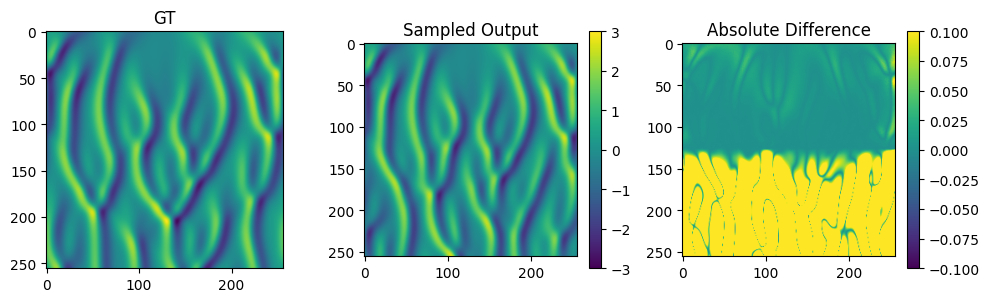

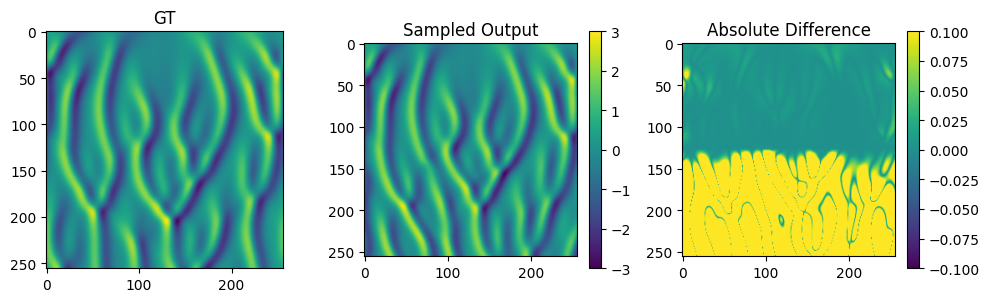

In [36]:
for i in range(2):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(X[1, 0], vmax=3, vmin=-3)
    axes[0].set_title('GT')
    a = axes[1].imshow(samples_cond_grad_dpmc[i, 0], vmax=3, vmin=-3)
    axes[1].set_title('Sampled Output')
    fig.colorbar(ax=axes[1], mappable=a, fraction = 0.05)
    b = axes[2].imshow(np.abs(X[1, 0] - samples_cond_grad_dpmc[i, 0]), vmax=0.1, vmin=-0.1)
    axes[2].set_title('Absolute Difference')
    fig.colorbar(ax=axes[2], mappable=b, fraction = 0.05)
    plt.tight_layout()
    plt.show()

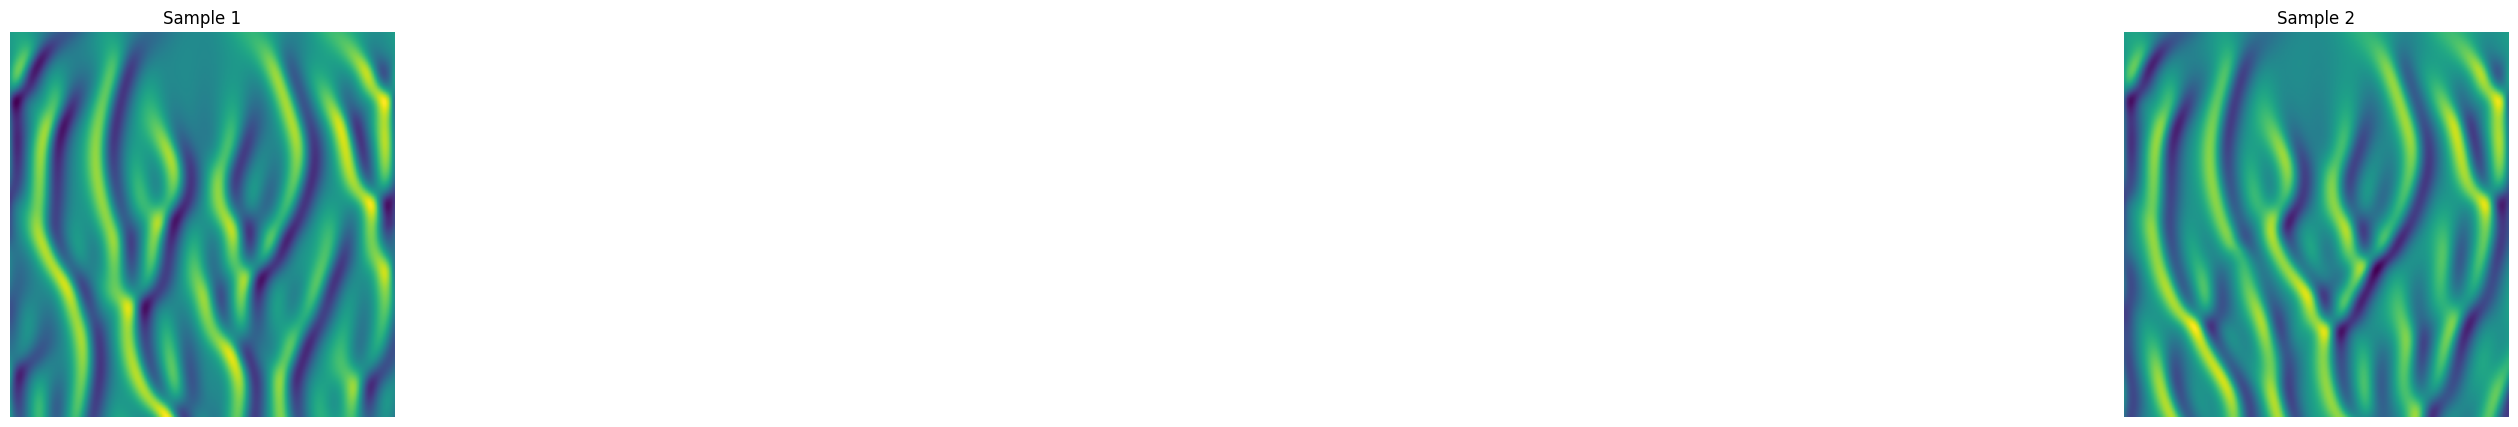

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(50, 5))
for i in range(2):
    axes[i].imshow(samples_cond_grad_dpmc[i, 0])
    axes[i].set_title(f'Sample {i+1}')
    axes[i].axis('off')
    
corr_grad = []
for s in (samples_cond_grad_dpmc):
    corr_grad.append(two_point_corr(s[0], np.arange(256), 0, 1)[-1])

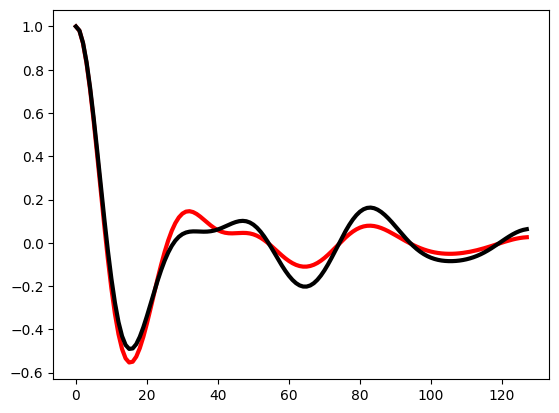

In [38]:
corr_grad = np.stack(corr_grad, axis=0)
# for i in range(20):
#     plt.plot(np.arange(128), corr_mcmc[i], label='MCMC')
plt.plot(np.arange(128), corr_grad.mean(axis=0), label='MCMC Mean', color='red', linewidth=3)
plt.plot(np.arange(128), two_point_corr(X[1,0], np.arange(256), 0, 1)[-1], label='GT', linewidth=3, color='black')
plt.show()

In [39]:
calculate_kuramoto_sivashinsky_residual((samples_cond_grad_dpmc * std + m)[:, 0], 0.2,0.245)

array([1.0421299 , 0.967913  , 1.0611876 , 0.8406391 , 1.185926  ,
       1.0126957 , 0.91319525, 1.042896  , 0.87003124, 1.2328708 ,
       1.0165237 , 0.92072207, 1.0332143 , 0.8345621 , 1.223729  ,
       1.0532925 , 0.96585757, 1.0536699 , 0.83268625, 1.1952392 ,
       1.0209976 , 0.9337451 , 1.0346009 , 0.8377426 , 1.2090681 ],
      dtype=float32)